In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
%matplotlib ipympl

MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}

In [2]:
point_name = 'middle'
df = pd.read_csv('../data/ai_ready/' + point_name + '_timeseries.csv', parse_dates=True)
df.set_index(pd.to_datetime(df['time']), inplace=True)
df.drop(columns=['time'], inplace=True)
df.drop(columns=['series'], inplace=True)
df = df.rename(columns={'velocity': 'target'})

df['timestamp'] = pd.to_datetime(df.index)  # Ensure date is datetime type
df = df.set_index('timestamp').resample('6D').mean(numeric_only=True)  # Resample to every 6 days frequency
df = df.interpolate()  # Interpolate missing values
df['item_id'] = 'A'
df.head()

,target,item_id
timestamp,,
2015-01-30,779.535340,A
2015-02-05,758.979735,A
2015-02-11,738.424130,A
2015-02-17,738.549458,A
2015-02-23,738.674785,A


## Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [8]:
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
PDT = 30  # prediction length: any positive integer
CTX = 150  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 150  # test set length: any positive integer

In [9]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id", freq="6D")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [10]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

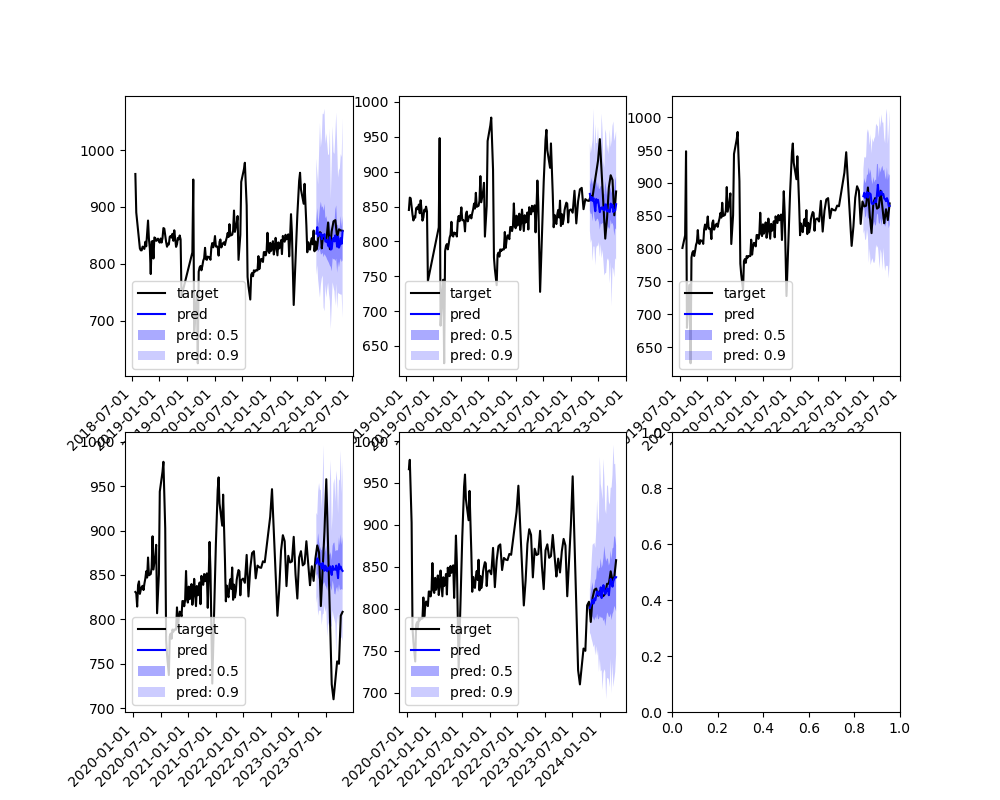

In [11]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)